# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.roc_auc_mean
    test_scores_std = df.roc_auc_std
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")
    

    plt.legend(loc="best")
    return plt

In [4]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_learning_curves_from_df(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
#     """
#     Plota múltiplas curvas de aprendizado (AUC-ROC) com cores suaves.
    
#     O DataFrame deve ter as colunas:
#     - 'roc_auc_mean'
#     - 'roc_auc_std'
#     - 'modelo'
#     """
#     plt.figure(figsize=(10, 6))
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Interações")
#     plt.ylabel("AUC-ROC")
#     plt.grid(True, linestyle='--', alpha=0.3)

#     modelos = df['modelo'].unique()

#     # Cores suaves e distintas
#     cores_suaves = [
#         '#66c2a5',  # verde claro
#         '#8da0cb',  # azul claro
#         '#fc8d62',  # laranja claro
#         '#e78ac3',  # rosa claro
#         '#a6d854',  # verde-limão
#         '#ffd92f',  # amarelo
#         '#e5c494',  # bege
#         '#b3b3b3',  # cinza claro
#         '#a1d99b',  # verde-menta
#         '#9ecae1'   # azul-celeste
#     ]

#     for idx, modelo in enumerate(modelos):
#         cor = cores_suaves[idx % len(cores_suaves)]
#         df_modelo = df[df['modelo'] == modelo]
#         plt.fill_between(train_sizes,
#                          df_modelo['roc_auc_mean'] - df_modelo['roc_auc_std'],
#                          df_modelo['roc_auc_mean'] + df_modelo['roc_auc_std'],
#                          alpha=0.15, color=cor)
#         plt.plot(train_sizes, df_modelo['roc_auc_mean'], label=modelo, color=cor, linewidth=2)

#     plt.legend(loc="best", frameon=True)
#     return plt



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_learning_curves_from_df(df, title, ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000)):
    """
    Plota múltiplas curvas de aprendizado (AUC-ROC) a partir de um DataFrame com várias execuções/modelos.

    Requer colunas:
    - 'roc_auc_mean': valores médios da AUC
    - 'roc_auc_std' : desvios padrão da AUC
    - 'modelo'      : nome do modelo (str), para agrupar as curvas
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    # plt.ylim(0, 1)  # Limite fixo para o eixo Y
    plt.xlabel("Iterações")
    plt.ylabel("AUC-ROC")
    plt.grid()

    modelos = df['modelo'].unique()

    # Cores bem distintas (adapte se houver mais modelos)
    cores_distintas = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'olive', 'pink']

    for idx, modelo in enumerate(modelos):
        cor = cores_distintas[idx % len(cores_distintas)]
        df_modelo = df[df['modelo'] == modelo]
        plt.fill_between(train_sizes,
                         df_modelo['roc_auc_mean'] - df_modelo['roc_auc_std'],
                         df_modelo['roc_auc_mean'] + df_modelo['roc_auc_std'],
                         alpha=0.1, color=cor)
        plt.plot(train_sizes, df_modelo['roc_auc_mean'], label=modelo, color=cor)

    plt.legend(loc="best")
    return plt

In [5]:
results_df_iforest_tpe = pd.read_csv(f'./metrics_anomaly_detection/results_iforest_tpe.csv')
results_df_iforest_cmaes = pd.read_csv(f'./metrics_anomaly_detection/results_iforest_cmaes.csv')
results_df_iforest_sac = pd.read_csv(f'./metrics_anomaly_detection/results_df_iforest.csv') 
results_df_iforest_sac  = results_df_iforest_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_iforest_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_iforest_tpe['modelo'] = 'TPE'
results_df_iforest_cmaes['modelo'] = 'CMA-ES'
results_df_iforest_sac['modelo'] = 'HBSAC-ADT'

results_df_iforest = pd.concat([results_df_iforest_sac, results_df_iforest_tpe, results_df_iforest_cmaes], axis=0)

results_df_lof_tpe = pd.read_csv(f'./metrics_anomaly_detection/results_lof_tpe.csv')
results_df_lof_cmaes = pd.read_csv(f'./metrics_anomaly_detection/results_lof_cmaes.csv')
results_df_lof_sac = pd.read_csv(f'./metrics_anomaly_detection/results_df_lof.csv')
results_df_lof_sac  = results_df_lof_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_lof_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_lof_tpe['modelo'] = 'TPE'
results_df_lof_cmaes['modelo'] = 'CMA-ES'
results_df_lof_sac['modelo'] = 'HBSAC-ADT'
results_df_lof = pd.concat([results_df_lof_sac, results_df_lof_tpe, results_df_lof_cmaes], axis=0)

results_df_pca_tpe = pd.read_csv(f'./metrics_anomaly_detection/results_pca_tpe.csv')
results_df_pca_cmaes = pd.read_csv(f'./metrics_anomaly_detection/results_pca_cmaes.csv')
results_df_pca_sac = pd.read_csv(f'./metrics_anomaly_detection/results_df_pca.csv')
results_df_pca_sac  = results_df_pca_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_pca_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_pca_tpe['modelo'] = 'TPE'
results_df_pca_cmaes['modelo'] = 'CMA-ES'
results_df_pca_sac['modelo'] = 'HBSAC-ADT'
results_df_pca = pd.concat([results_df_pca_sac, results_df_pca_tpe, results_df_pca_cmaes], axis=0)

results_df_loda_tpe = pd.read_csv(f'./metrics_anomaly_detection/results_loda_tpe.csv')
results_df_loda_cmaes = pd.read_csv(f'./metrics_anomaly_detection/results_loda_cmaes.csv')
results_df_loda_sac = pd.read_csv(f'./metrics_anomaly_detection/results_df_loda.csv')
results_df_loda_sac  = results_df_loda_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_loda_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_loda_tpe['modelo'] = 'TPE'
results_df_loda_cmaes['modelo'] = 'CMA-ES'
results_df_loda_sac['modelo'] = 'HBSAC-ADT'
results_df_loda = pd.concat([results_df_loda_sac, results_df_loda_tpe, results_df_loda_cmaes], axis=0)

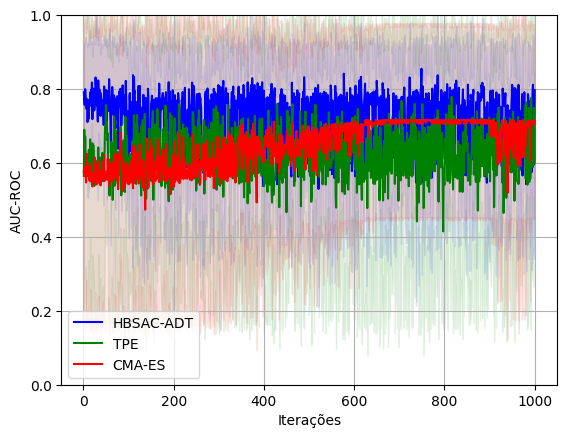

In [6]:
plot_learning_curves_from_df(results_df_iforest, title="")
plt.show()

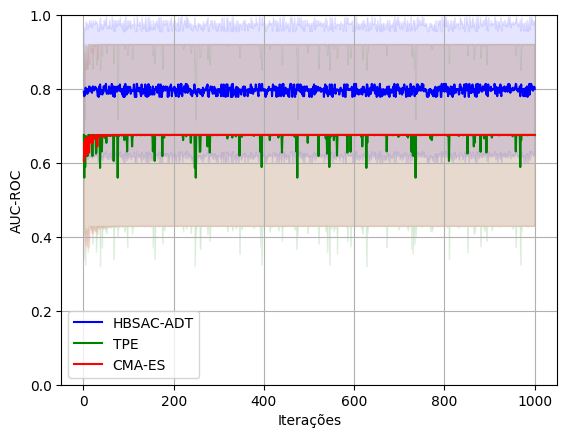

In [7]:
plot_learning_curves_from_df(results_df_lof, title="")
plt.show()

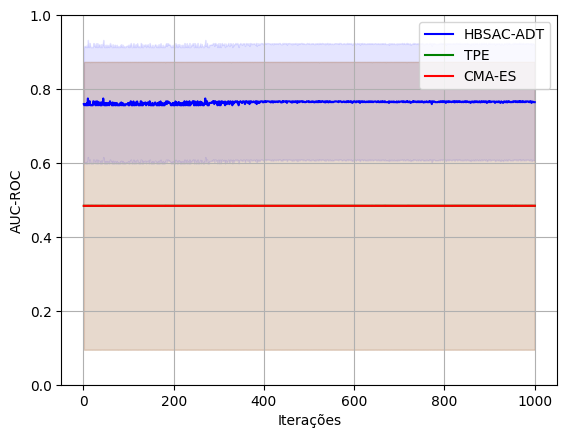

In [8]:
plot_learning_curves_from_df(results_df_pca, title="")
plt.show()

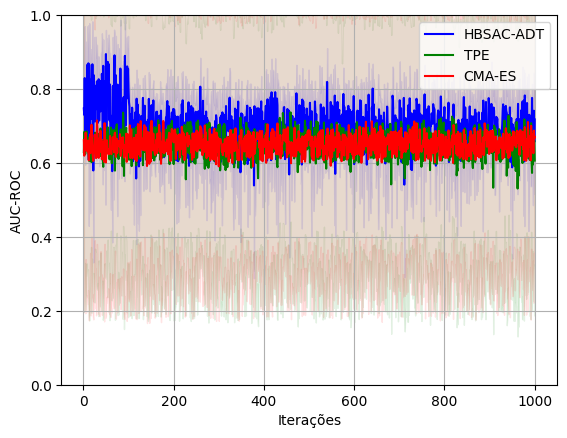

In [9]:
plot_learning_curves_from_df(results_df_loda, title="")
plt.show()

In [10]:
train = pd.read_parquet('./dataset/train_agg.parquet.gzip') 
test = pd.read_parquet('./dataset/test_agg.parquet.gzip') 

In [11]:
feature_model = [col for col in train.columns if col not in ['timestamp', 'well', 'target']]

In [12]:
validation = test.reset_index(drop=True)
validation.shape

(7399, 27)

In [13]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [15]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X)

In [19]:
with open('./models/pipeline_iForest_cmaes.pkl', 'rb') as file:
    pipe_model_iforest_cmaes = pickle.load(file)
with open('./models/pipeline_LOF_cmaes.pkl', 'rb') as file:
    pipe_model_lof_cmaes = pickle.load(file)
with open('./models/pipeline_LODA_cmaes.pkl', 'rb') as file:
    pipe_model_loda_cmaes = pickle.load(file)
with open('./models/pipeline_PCA_cmaes.pkl', 'rb') as file:
    pipe_model_pca_cmaes = pickle.load(file)

with open('./models/pipeline_iForest_tpe.pkl', 'rb') as file:
    pipe_model_iforest_tpe = pickle.load(file)
with open('./models/pipeline_LOF_tpe.pkl', 'rb') as file:
    pipe_model_lof_tpe = pickle.load(file)
with open('./models/pipeline_LODA_tpe.pkl', 'rb') as file:
    pipe_model_loda_tpe = pickle.load(file)
with open('./models/pipeline_PCA_tpe.pkl', 'rb') as file:
    pipe_model_pca_tpe = pickle.load(file)

with open('./models/pipeline_iForest_RL.pkl', 'rb') as file:
    pipe_model_iforest_hbsac = pickle.load(file)
with open('./models/pipeline_LOF_RL.pkl', 'rb') as file:
    pipe_model_lof_hbsac = pickle.load(file)
with open('./models/pipeline_LODA_RL.pkl', 'rb') as file:
    pipe_model_loda_hbsac = pickle.load(file)
with open('./models/pipeline_PCA_RL.pkl', 'rb') as file:
    pipe_model_pca_hbsac = pickle.load(file)

In [20]:
# Supondo que você já tenha os pipelines carregados e X_valid, y_valid
pipelines = {
    "iForest": {"HBSAC-ADT": pipe_model_iforest_hbsac,
                "CMA-ES": pipe_model_iforest_cmaes,
                "TPE": pipe_model_iforest_tpe},
    "LOF": {"HBSAC-ADT": pipe_model_lof_hbsac,
            "CMA-ES": pipe_model_lof_cmaes,
            "TPE": pipe_model_lof_tpe},
    "LODA": {"HBSAC-ADT": pipe_model_loda_hbsac,
             "CMA-ES": pipe_model_loda_cmaes,
             "TPE": pipe_model_loda_tpe},
    "PCA": {"HBSAC-ADT": pipe_model_pca_hbsac,
            "CMA-ES": pipe_model_pca_cmaes,
            "TPE": pipe_model_pca_tpe},
}

binary_predictions = {}

for model_name, method_pipes in pipelines.items():
    binary_predictions[model_name] = {}
    for method_name, pipe in method_pipes.items():
        # Gera predições binárias diretas
        y_pred = pipe.predict(X_valid)

        # Converte convenção (-1 = anômalo → 1, 1 = normal → 0) para LOF e iForest
        if model_name in ["iForest", "LOF"]:
            y_pred = np.where(y_pred == -1, 1, 0)

        binary_predictions[model_name][method_name] = y_pred



McNemar p-values for iForest


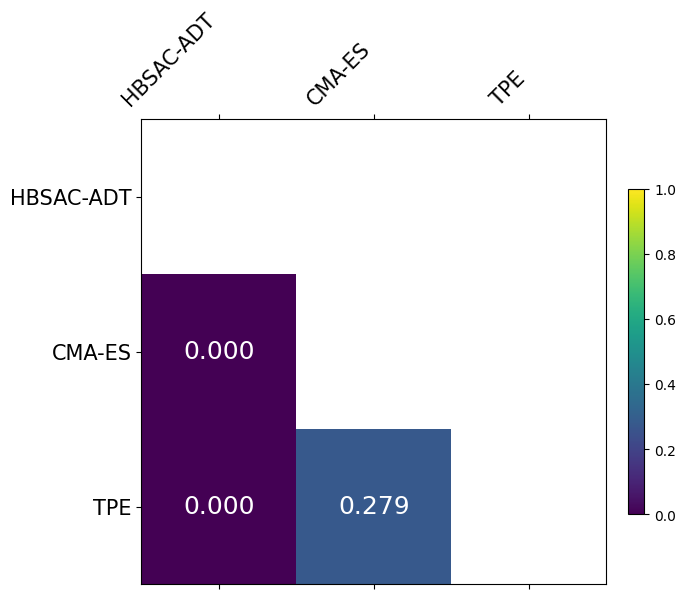

McNemar p-values for LOF


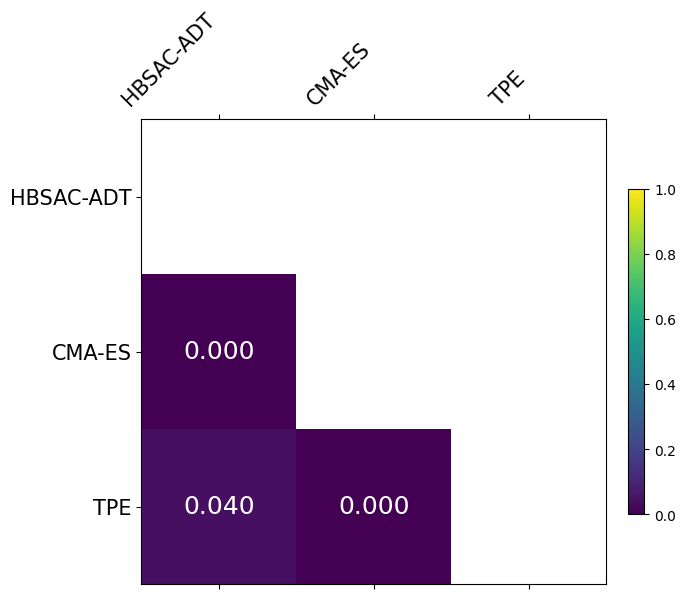

McNemar p-values for LODA


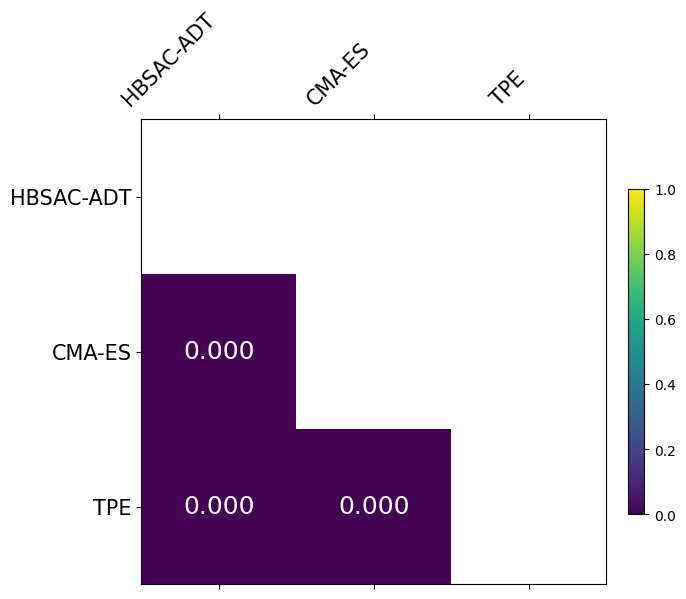

McNemar p-values for PCA


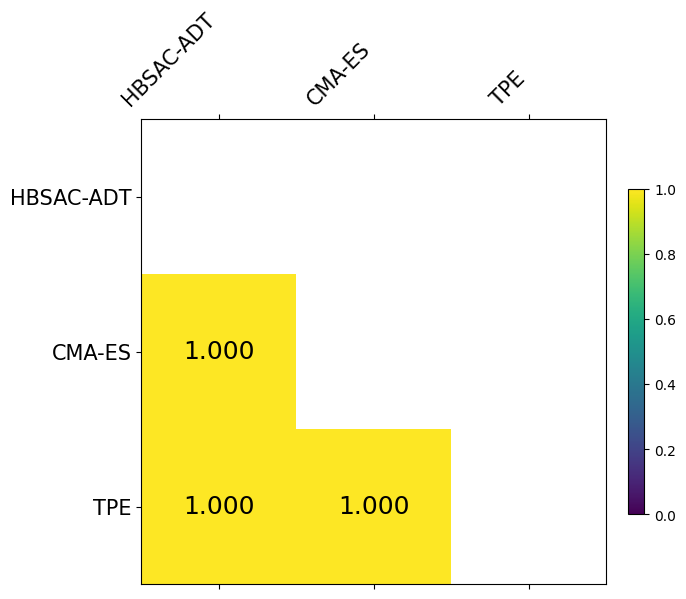

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.evaluate import mcnemar_table
from statsmodels.stats.contingency_tables import mcnemar

models = ["iForest", "LOF", "LODA", "PCA"]
methods = ["HBSAC-ADT", "CMA-ES", "TPE"]

for model in models:
    n_methods = len(methods)
    mat = np.full((n_methods, n_methods), np.nan)
    
    # Comparação entre métodos
    for i in range(n_methods):
        for j in range(i):
            y_pred1 = binary_predictions[model][methods[i]]
            y_pred2 = binary_predictions[model][methods[j]]
            
            # Gera tabela de contingência
            table = mcnemar_table(y_target=y_valid, y_model1=y_pred1, y_model2=y_pred2)
            result = mcnemar(table, exact=True)
            mat[i, j] = result.pvalue
    
    # Plot da matriz triangular
    plt.figure(figsize=(7,6))
    cax = plt.matshow(mat, cmap="viridis", vmin=0, vmax=1, fignum=1)
    print(f"McNemar p-values for {model}")
    
    # Labels
    plt.xticks(range(n_methods), methods, rotation=45, ha="right", fontsize=15)
    plt.yticks(range(n_methods), methods, fontsize=15)
    
    # Inserir p-valores nas células
    for r in range(n_methods):
        for c in range(n_methods):
            if r > c:
                val = mat[r,c]
                plt.text(c, r, f"{val:.3f}", va='center', ha='center', 
                         color="white" if val < 0.5 else "black", fontsize=18)
    
    plt.colorbar(cax, fraction=0.03, pad=0.04)
    plt.tight_layout()
    plt.show()

### Q-values

In [31]:
results_q_values_iforest = pd.read_csv(f'./metrics_anomaly_detection/q_values_history_iforest.csv')
results_q_values_lof = pd.read_csv(f'./metrics_anomaly_detection/q_values_history_lof.csv')
results_q_values_pca = pd.read_csv(f'./metrics_anomaly_detection/q_values_history_pca.csv')
results_q_values_loda = pd.read_csv(f'./metrics_anomaly_detection/q_values_history_loda.csv')

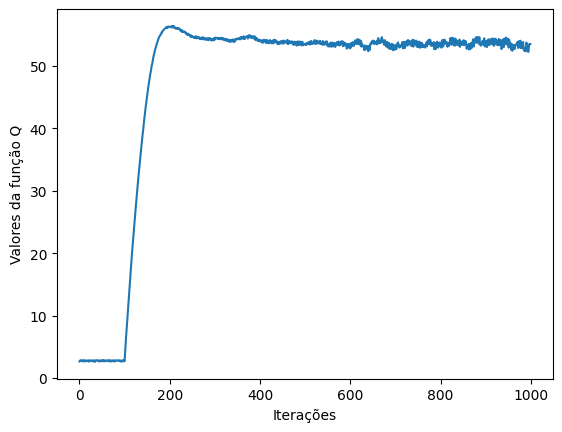

In [32]:
plt.plot(results_q_values_iforest)
plt.xlabel("Iterações")
plt.ylabel("Valores da função Q")
plt.show()

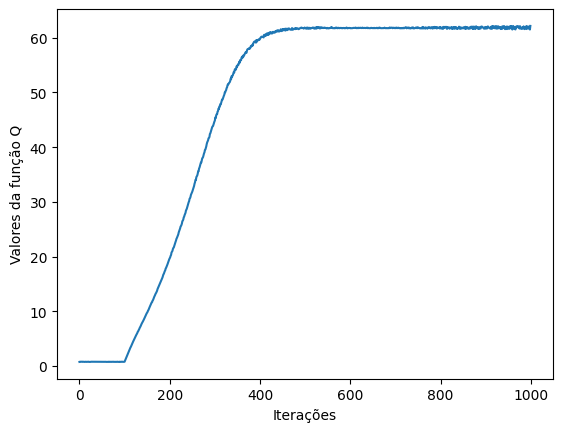

In [33]:
plt.plot(results_q_values_lof)
plt.xlabel("Iterações")
plt.ylabel("Valores da função Q")
plt.show()

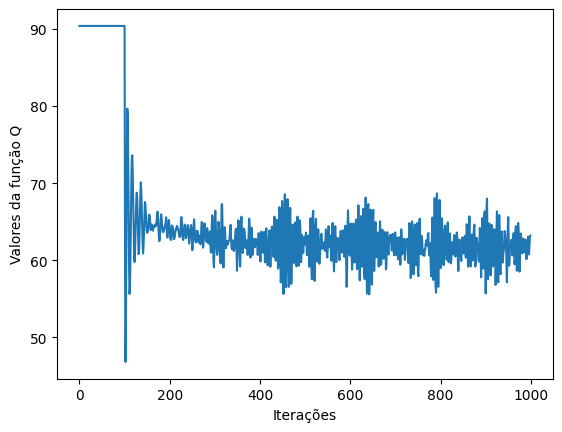

In [34]:
plt.plot(results_q_values_loda)
plt.xlabel("Iterações")
plt.ylabel("Valores da função Q")
plt.show()

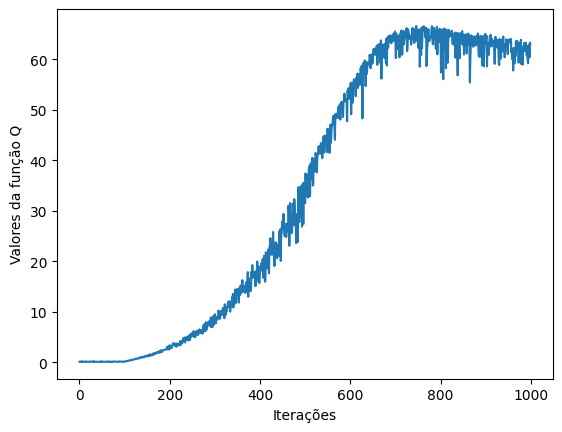

In [35]:
plt.plot(results_q_values_pca)
plt.xlabel("Iterações")
plt.ylabel("Valores da função Q")
plt.show()

### Análise TPE

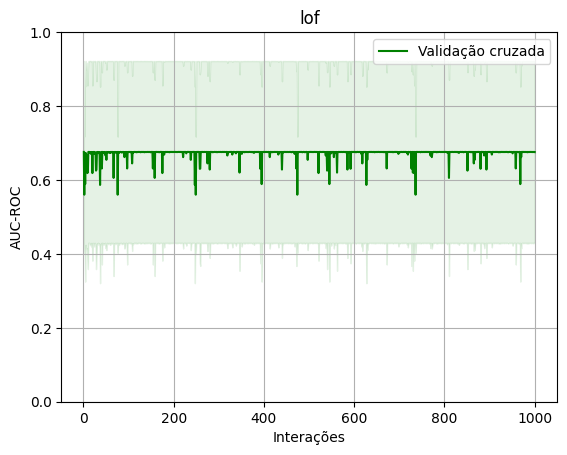

In [17]:

for i in ['lof', 'iforest', 'pca', 'loda']:

    results_df = pd.read_csv(f'./metrics_anomaly_detection/results_{i}_tpe.csv')

    results_df  = results_df[['roc_auc_mean', 'roc_auc_std']]

    plot_learning_curve_cross_validation(results_df, title=f"{i}", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))
    break

In [5]:
# for i in ['lof', 'iforest', 'pca', 'loda']:

results_df_iforest = pd.read_csv(f'./metrics_anomaly_detection/results_iforest_tpe.csv')

In [6]:
results_df_iforest.head()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features
0,0,0.564991,0.407139,15.785239,191,0.001028,0.362646,0.510361
1,1,0.689712,0.371502,31.821071,35,0.003702,0.996487,0.751865
2,2,0.594817,0.416144,17.867311,242,0.004911,0.819264,0.490132
3,3,0.671598,0.352909,31.868900,17,0.004015,0.916257,0.355029
4,4,0.586254,0.414619,17.163534,204,0.003180,0.479846,0.372409


In [10]:
results_df_iforest.tail()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features,roc_auc_adjusted
995,995,0.589222,0.219074,37.014845,5,0.003288,0.555234,0.717666,0.370148
996,996,0.651944,0.386667,26.527749,13,0.003116,0.959666,0.702741,0.265277
997,997,0.748852,0.239915,50.893690,5,0.003151,0.975722,0.702443,0.508937
998,998,0.688784,0.287810,40.097460,9,0.003284,0.989248,0.710956,0.400975
999,999,0.599873,0.330156,26.971683,5,0.003153,0.975885,0.719536,0.269717


In [9]:
results_df_iforest['roc_auc_adjusted'] = results_df_iforest['roc_auc_mean'] - results_df_iforest['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = results_df_iforest.loc[999]
best_params = results_df_iforest.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMétricas:", best_params) 


Métricas: trial               810.000000
roc_auc_mean          0.755599
roc_auc_std           0.225249
value                53.035032
n_estimators          5.000000
contamination         0.004540
max_samples           0.976874
max_features          0.663929
roc_auc_adjusted      0.530350
Name: 810, dtype: float64


In [18]:
results_df.head()

,roc_auc_mean,roc_auc_std
0,0.675847,0.245877
1,0.560133,0.157259
2,0.666192,0.250763
3,0.588830,0.263843
4,0.673182,0.248715


### Análise do CMA-ES

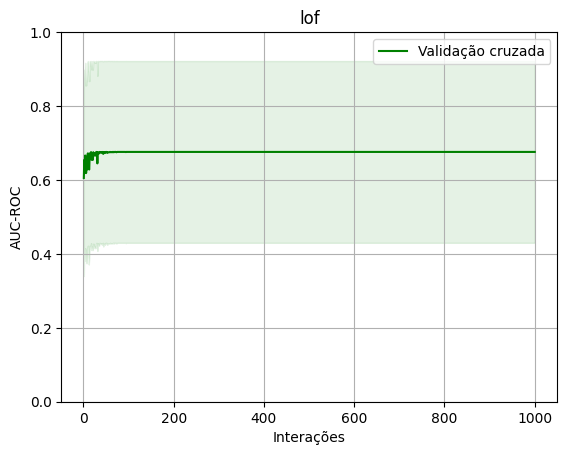

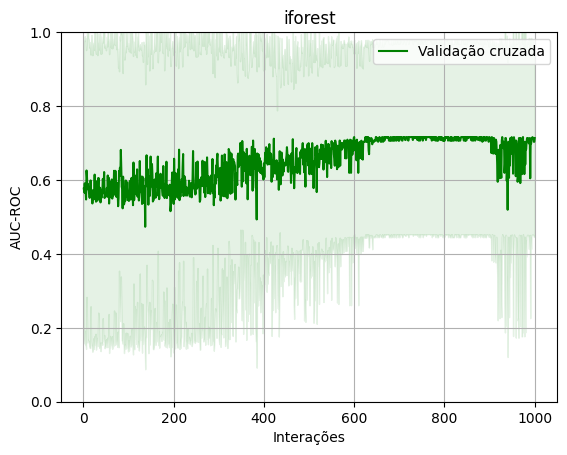

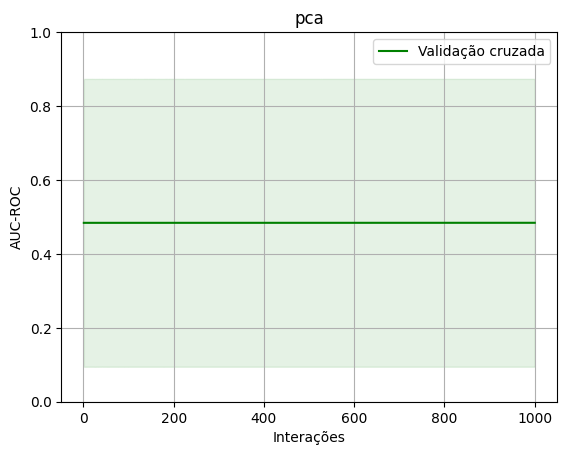

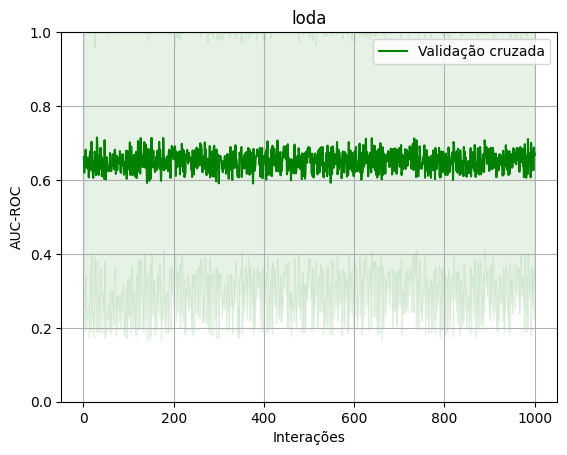

In [15]:

for i in ['lof', 'iforest', 'pca', 'loda']:

    results_df = pd.read_csv(f'./metrics_anomaly_detection/results_{i}_cmaes.csv')

    results_df  = results_df[['roc_auc_mean', 'roc_auc_std']]

    plot_learning_curve_cross_validation(results_df, title=f"{i}", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))